In [1]:
import re
import os 
import sys 

import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

from pathlib import Path
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed
from skimage import exposure
import h5py
import pandas as pd
import scanpy as sc
import squidpy as sq
sc.settings.verbosity = 3

from matplotlib.pyplot import rc_context
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from functools import reduce
from matplotlib import cm, colors
import scanorama
import seaborn as sns 
import anndata as ad
from PIL import Image

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [4]:
from config import *
import my_io as io

In [5]:
data_ROI = data_dir / 'ROI_new'
dataset = 'ROI002'

# Load data

In [216]:
from sklearn.neighbors import NearestNeighbors

def get_NN(data, n):
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    distances, indices = fit.kneighbors(data)

    return distances, indices

def filter_img_knn(img, n=25, th=3.5):
    # Get avg distances per positive expressed pixels
    x, y = np.where(img > 0)
    values = img[x,y]
    
    data = np.column_stack((x,y))
    distances, indices = get_NN(data, n)
    # avg_dist = np.average(distances, axis=1, weights=values[indices])
    avg_dist = np.average(distances, axis=1)
        
    filter_ind = avg_dist > th
    unique, counts = np.unique(filter_ind, return_counts=True)
    print(unique, counts)
    x_fil = x[filter_ind]
    y_fil = y[filter_ind]

    img_fil = img.copy()
    img_fil[x_fil, y_fil] = 0
    
    return img_fil

def read_img(ROI: str, data_ROI):
    """Read all image from one ROI"""
    dir_ = data_ROI / ROI

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    img_name = [
        name
        for name in sorted(filenames)
        if "tiff" in name and 'contaminant' not in name
    ]
    markers = [name.split("_")[-1].split(".")[0] for name in img_name]
    imgs = np.stack(
        [skimage.io.imread(os.path.join(dirpath, name), True) for name in img_name], axis=0
    )
    return imgs, markers

def contrast_streching(img):
    p2, p98 = np.percentile(img, (1,99))
    return exposure.rescale_intensity(img, in_range=(p2, p98))

def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_ROI 

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'Cell Mask' in name and ROI in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def read_intensity_per_cell(img, mask):
    props = skimage.measure.regionprops_table(mask, img,
                                             properties = ['label', 'mean_intensity', 'area'] )
    df_prop = pd.DataFrame(props)
    df_prop['mean_intensity'] = df_prop['mean_intensity']
    df_prop.drop('area', axis=1, inplace=True)
        
    # x_scaled = MinMaxScaler().fit_transform(df_prop[['mean_intensity']])
    # df_prop['mean_intensity'] = x_scaled
    
    return df_prop

In [7]:
imgs, markers = read_img(dataset, data_ROI)
imgs = joblib_loop(contrast_streching, imgs)

In [8]:
imgs_filtered = []

for i, img in enumerate(imgs):
    print(markers[i])
    if markers[i] in ['CD103']:
        img_filtered = filter_img_knn(img, th=5)
    else:
        img_filtered = filter_img_knn(img, th=3.5)
    
    # fig, ax = plt.subplots(1,2,figsize=(20,10))
    # ax[0].imshow(img[700:1300, 700:1300], interpolation=None, cmap='hot')
    # ax[0].axis('off')
    # ax[1].imshow(img_filtered[700:1300, 700:1300], interpolation=None, cmap='hot')
    # ax[1].axis('off')
    # fig.subplots_adjust(wspace=0.01)
    # plt.show()
    
    imgs_filtered.append(img_filtered)

SMA
[False  True] [880669  53609]
Vimentin
[False  True] [878104  60781]
TCF1
[False  True] [131165 222484]
CD163
[False  True] [121094 172535]
Pankeratin
[False  True] [194099 172013]
H3K9me3
[False  True] [386676 142847]
PDL1
[False  True] [365602 147634]
CD103
[False  True] [21938 88502]
CD206
[False  True] [ 93151 151985]
CD11c
[False  True] [678011  43144]
FoxP3
[False  True] [335955 154390]
CD4
[False  True] [159245 162882]
E-cadherin
[False  True] [1281117   12600]
CD68
[False  True] [563554 111628]
CD95
[False  True] [   893 106396]
CD20
[False  True] [ 88846 164452]
CD8
[False  True] [1329852   10901]
PD1
[False  True] [  4589 144430]
GranenzymeB
[False  True] [ 27757 153865]
Ki67
[False  True] [  8191 157063]
COL1
[False  True] [559822 111686]
CD3
[False  True] [286595 163888]
Histone3
[False  True] [1677937   28997]
CD45Ro
[False  True] [1280884   10730]
HLADR
[False  True] [1081371   17542]
MHC-II
[False  True] [1423973    8513]


In [217]:
mask = read_cell_mask(dataset)
# marker_subset = ['SMA', 'Vimentin', 'TCF1', 'CD163', 'Pankeratin', 'CD206', 'CD4', 'E-cadherin', 'CD68', 'CD20', 'CD8', 'GranenzymeB', 'Ki67', 'COL1', 'CD3', 'HLADR']
marker_subset = ['SMA', 'Vimentin', 'TCF1', 'CD163', 'Pankeratin', 'CD206', 'E-cadherin', 'CD68', 'CD8', 'GranenzymeB', 'KI67', 'COL1', 'CD3', 'HLADR', 'MHC-II', 'CD11c']

df_appended_list = []
for i, img in enumerate(imgs_filtered):
    if markers[i] in marker_subset:
        df_prop = read_intensity_per_cell(img, mask)
        df_prop.columns = ['Cell_label', markers[i]]
        df_appended_list.append(df_prop)

# Combine dataframe
df = reduce(lambda left,right: pd.merge(left,right,on=['Cell_label']), df_appended_list)

props = skimage.measure.regionprops_table(mask, properties = ['label', 'centroid'] )
rows = props['centroid-0'] 
cols = props['centroid-1'] 
centroid = np.array(list(zip(cols,rows)))

# Clustering

In [218]:
df_intensity = df.iloc[:,1:]

In [219]:
# Create annData from dataframe
adata = sc.AnnData(df_intensity.values)
adata.var_names = df_intensity.columns.tolist() # add variable name

# Add obs information
adata.obs['Cell'] = df.Cell_label.tolist()
adata.obsm['spatial'] = centroid

In [220]:
sc.pp.scale(adata, max_value=2.5)

In [221]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [222]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


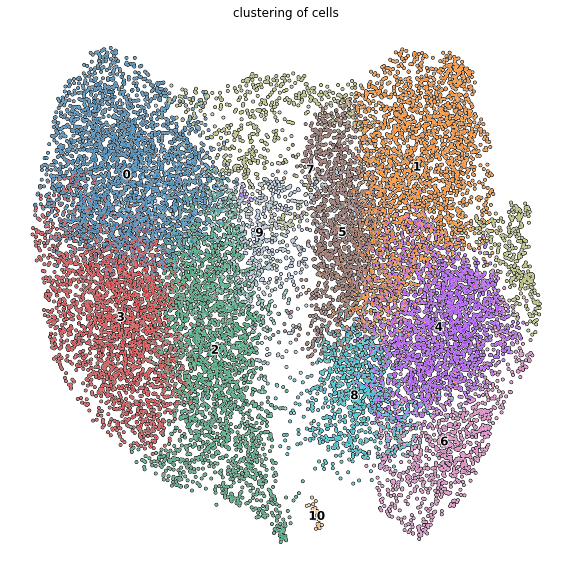

In [223]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color=['leiden'], size=20, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=12, legend_fontoutline=2, 
               frameon=False,  title='clustering of cells')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


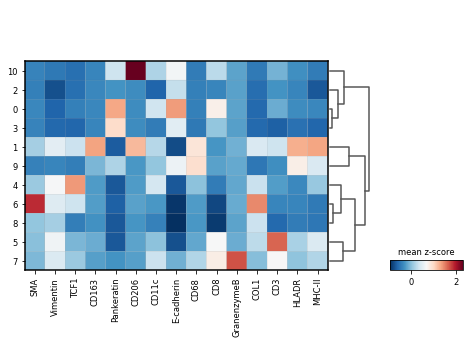

In [224]:
sc.pl.matrixplot(adata, adata.var_names.tolist(), 'leiden', dendrogram=True,
                 colorbar_title='mean z-score', cmap='RdBu_r')

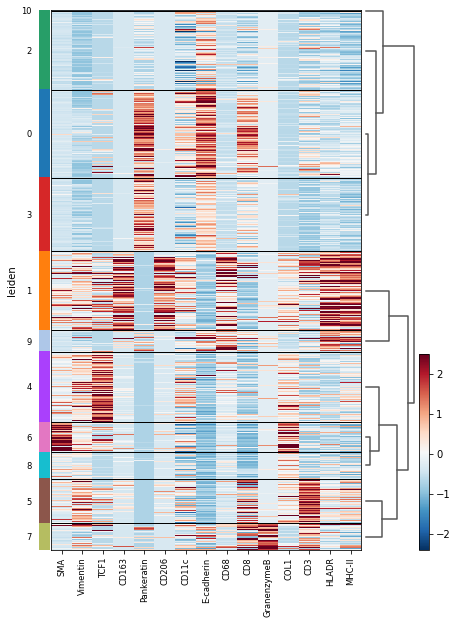

In [225]:
sc.pl.heatmap(adata, adata.var_names.tolist(), 'leiden', dendrogram=True, cmap='RdBu_r', figsize=(7,10))

# Viz

In [228]:
import matplotlib 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    
    return img 

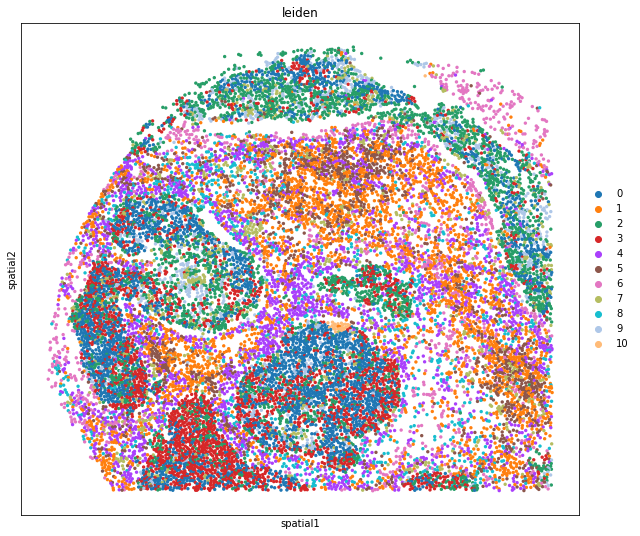

In [229]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color="leiden", spot_size=10)

In [230]:
colors = adata.uns['leiden_colors']
labels = np.unique(adata.obs.leiden.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb)*255
colors_rgb = colors_rgb.astype(np.uint8)

In [231]:
# Get label2cell dict
label2cell = {}
for l in labels:
    cell_id = adata[adata.obs.leiden == l].obs.Cell.to_list()
    label2cell[l] = cell_id

img = create_clustered_cell(mask, label2cell, colors_rgb)

  0%|          | 0/11 [00:00<?, ?it/s]

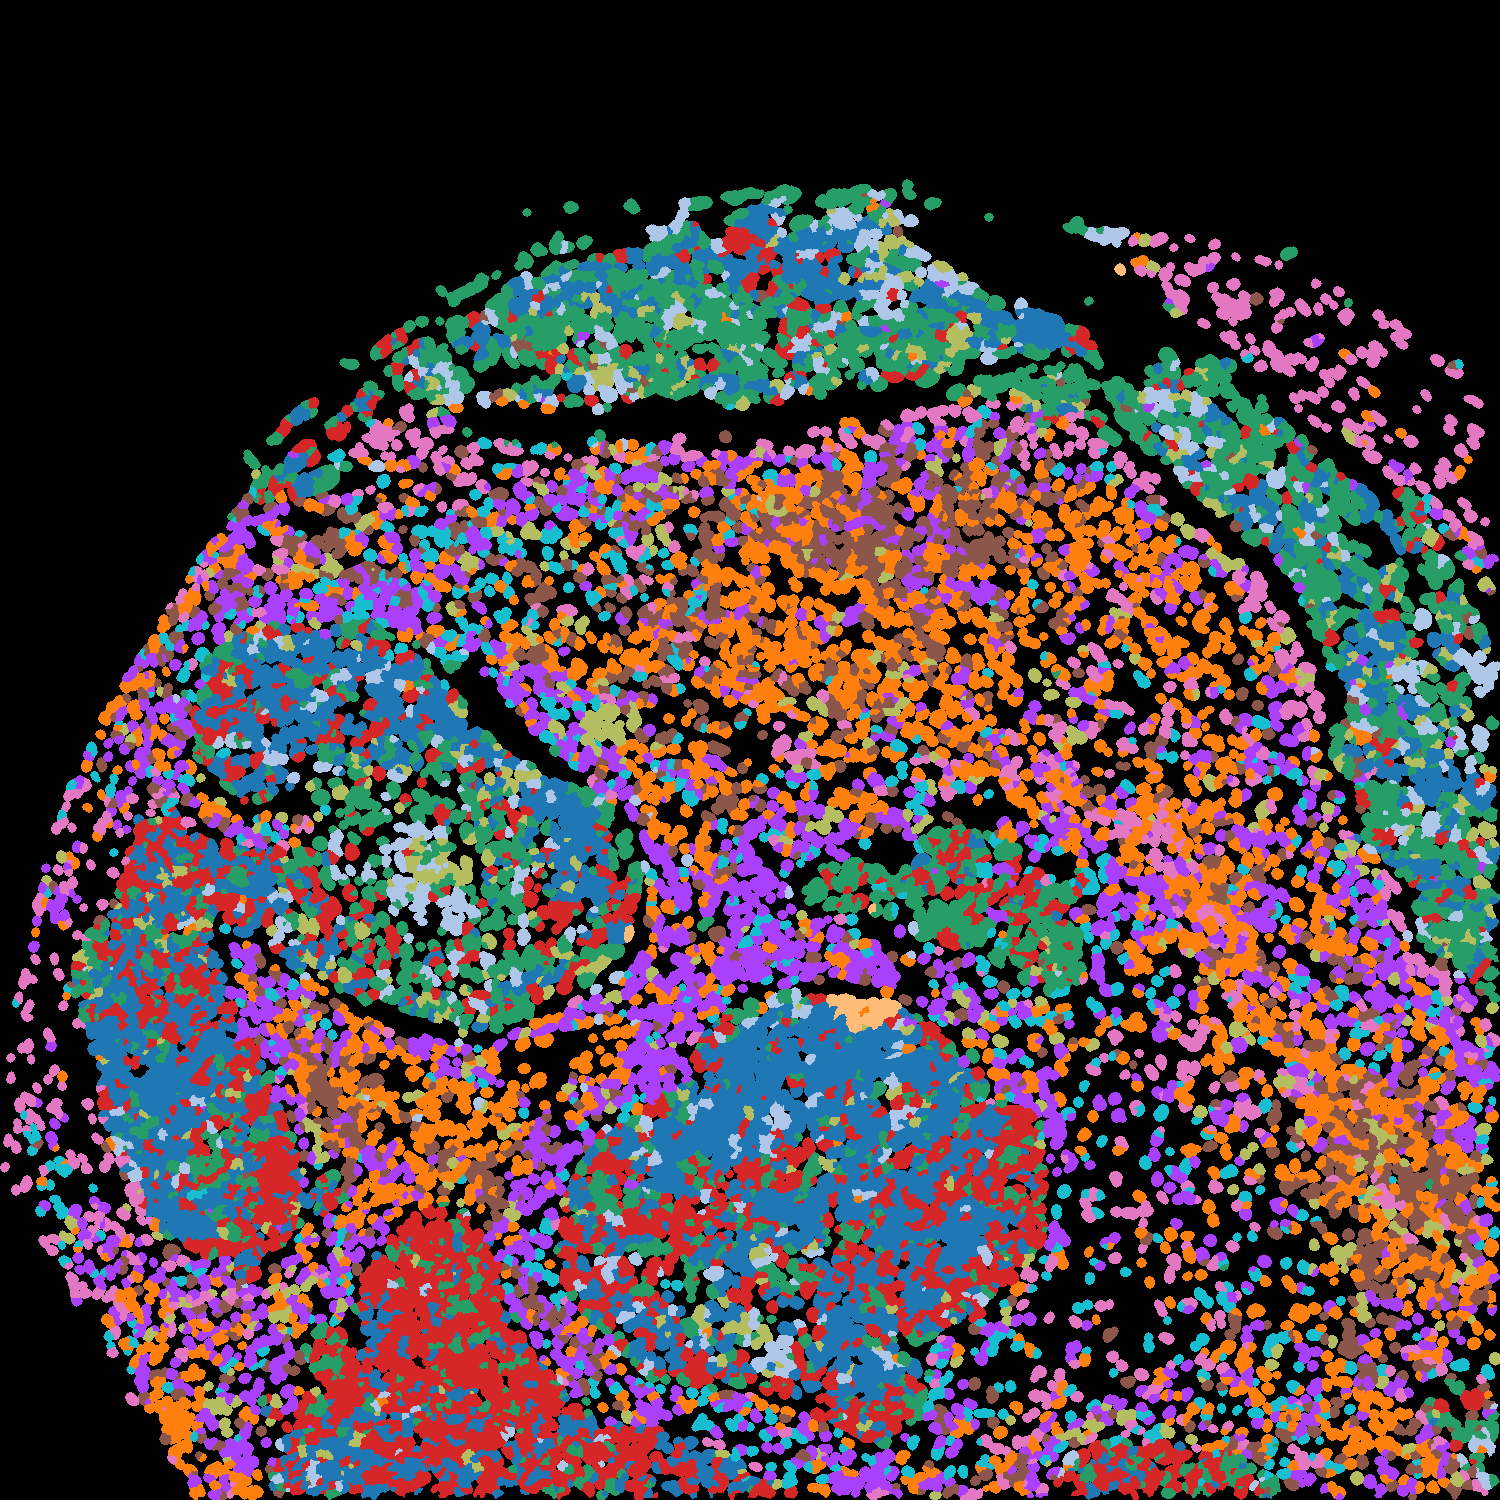

In [235]:
# img = Image.fromarray(img)
img

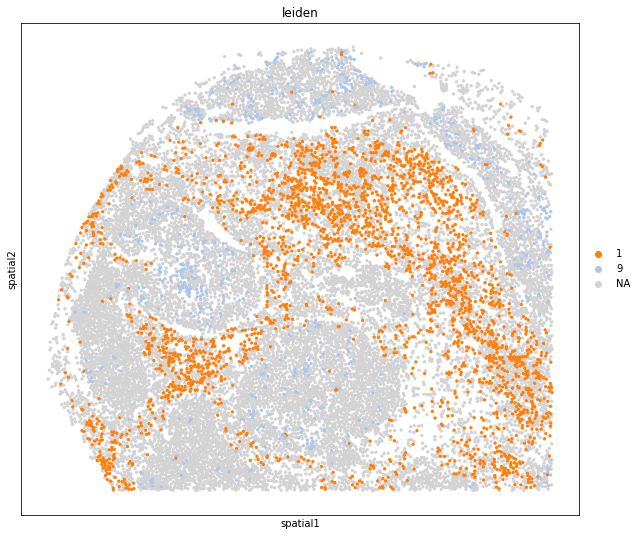

In [236]:
macrophage = ['1', '9']
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color="leiden", groups=macrophage ,spot_size=10)

In [237]:
# Get label2cell dict
label2cell = {}
for l in macrophage:
    cell_id = adata[adata.obs.leiden == l].obs.Cell.to_list()
    label2cell[l] = cell_id

img = create_clustered_cell(mask, label2cell, colors_rgb)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

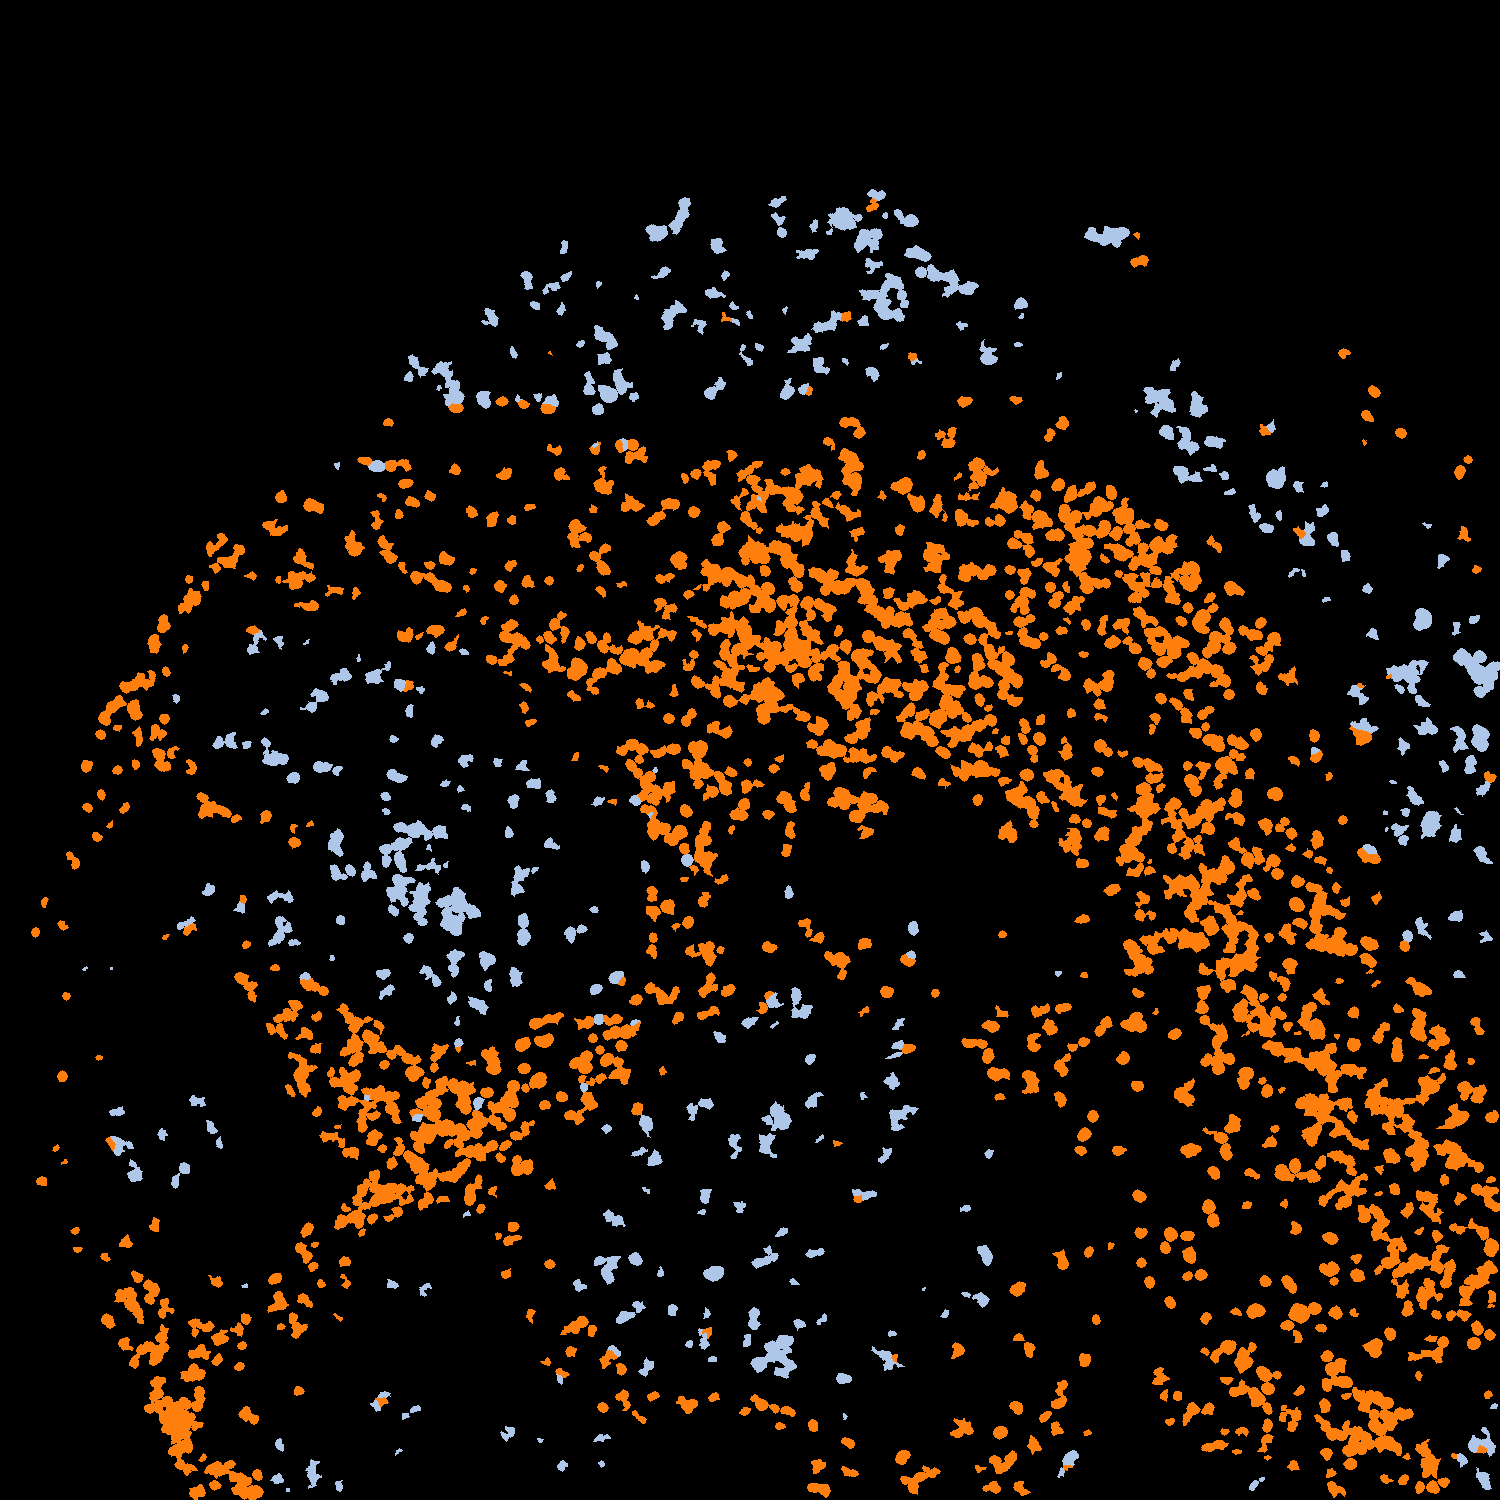

In [238]:
img = create_clustered_cell(mask, label2cell, colors_rgb)
img = Image.fromarray(img)
img

In [215]:
# import napari 

# viewer = napari.view_image(np.stack(imgs_filtered), channel_axis=0, name=markers)
# viewer.add_labels(mask)

<Labels layer 'mask' at 0x23611cef370>